## 2 [indicateur](#section_2) 
## 3 [prédiction](#section_3) 
## 4 [évaluation](#section_4) 
## 5 [bot](#section_5) 

In [1]:
import pandas as pd
from binance.client import Client
import ta
import pandas_ta as pda
import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV


In [2]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

# ----- Functions Definition -------
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:
            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(14,14))
            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            else  :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            # affichage des flèches
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")         
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)           
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)     
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')
            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
            
def get_chop(high, low, close, window):
    tr1 = pd.DataFrame(high - low).rename(columns = {0:'tr1'})
    tr2 = pd.DataFrame(abs(high - close.shift(1))).rename(columns = {0:'tr2'})
    tr3 = pd.DataFrame(abs(low - close.shift(1))).rename(columns = {0:'tr3'})
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').dropna().max(axis = 1)
    atr = tr.rolling(1).mean()
    highh = high.rolling(window).max()
    lowl = low.rolling(window).min()
    ci = 100 * np.log10((atr.rolling(window).sum()) / (highh - lowl)) / np.log10(window)
    return ci


def getBalance(myclient, coin):
    jsonBalance = myclient.get_balances()
    pandaBalance = pd.DataFrame(jsonBalance)
    if pandaBalance.loc[pandaBalance['coin'] == coin].empty : return 0
    else : return float(pandaBalance.loc[pandaBalance['coin'] == coin]['free'])

def truncate(n, decimals=0):
    r = floor(float(n*0.99)*10**decimals)/10**decimals
    return str(r)


#valeur à prédire

def plus_x_fois_j(data,x=3,j=1):
    from scipy.special import cbrt #racine cubique 3
    data['plus_x']=np.nan
    for i, date in enumerate(data[:-x].index) :
        data.loc[date,'plus_x'] = cbrt((data.iloc[i+x]['close']/data.iloc[i]['close']-1)*100*j)
    return data

def plus_x_classifier_h_l(data,x=3,h=1,l=-1):
    from scipy.special import cbrt #racine cubique 3
    data['plus_x']=np.nan
    for i, date in enumerate(data[:-x].index) :
        v=(data.iloc[i+x]['close']/data.iloc[i]['close']-1)*100
        if   v >=  h :
            data.loc[date,'plus_x'] = 3
        elif v =< l :
            data.loc[date,'plus_x'] = 1
        else :
            data.loc[date,'plus_x'] = 2
    return data

#indicateur
def indicator(data):
    data['VarianceHigh']  = (data['high']-data['close'])
    data['VarianceLow']   = (data['close']-data['low'])
    data['RollingMax']    = data['close'].shift(1).rolling(window=28).max()
    data['RollingMin']    = data['close'].shift(1).rolling(window=28).min()
    data['SMA']=ta.trend.sma_indicator(data['close'], window=12)

    #Relative Strength Index (RSI)
    data['RSI'] =ta.momentum.rsi(close=data['close'], window=14)

    # #Average True Range (ATR) trop de NAN
    data['ATR'] = ta.volatility.average_true_range(high=data['high'], low=data['low'], close=data['close'], window=14)

    # #Stochastic RSI
    data['STOCH_RSI'] = ta.momentum.stochrsi(close=data['close'], window=14, smooth1=3, smooth2=3) #Non moyenné 
    data['STOCH_RSI_D'] = ta.momentum.stochrsi_d(close=data['close'], window=14, smooth1=3, smooth2=3) #Orange sur TradingView
    data['STOCH_RSI_K'] =ta.momentum.stochrsi_k(close=data['close'], window=14, smooth1=3, smooth2=3) #Bleu sur TradingView

    # #Choppiness index
    data['CHOP'] = get_chop(high=data['high'], low=data['low'], close=data['close'], window=14)  
    
    
    return data

def evaluation(data_t):
    frais=0.00067
    btc=0.0
    usdt=100
    lastindex=data_t.first_valid_index()

    for index,row in data_t.iterrows():
        if  data_t['buy'][index] and usdt>10:
            btc =usdt/data_t['close'][index]
            btc = btc - (frais*btc)
            usdt=0
            print(f"{btc:.0f} btc                                         ",index)

        if data_t['sell'][index] and btc > 0.0001:
            usdt =btc*data_t['close'][index]
            usdt = usdt -(0.007*usdt)
            btc=0
            print(f"                      {usdt:.0f} $                     ",index)
        lastindex=index

    return usdt +btc*data_t['close'].iloc[-1]


In [30]:
from scipy.special import cbrt 
cbrt(0.1)

0.4641588833612779

# <a class="anchor" id="section_2"></a> indicateur

In [3]:
#gestion des dichiers
import os
from pathlib import Path
import pickle
import wget 

if not Path( r'./Data/btcusdt_train.pkl').is_file() :
    print('dl le fichier dans data en cours: ')
    os.makedirs('./Data/', exist_ok=True)
    client = Client()
    klinesT = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "01 january 2012")

    df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    df['close'] = pd.to_numeric(df['close'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['open'] = pd.to_numeric(df['open'])

    df = df.set_index(df['timestamp'])
    df.index = pd.to_datetime(df.index, unit='ms')
    df = df.drop( ['timestamp','open',
                   'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'],axis=1)

    df.to_pickle(r'./Data/btcusdt_train.pkl')
else:
    df= pd.read_pickle(r'./Data/btcusdt_train.pkl')
    

df=plus_x_fois_j(df,1,5)
df=indicator(df)    
df

,high,low,close,volume,plus_x,VarianceHigh,VarianceLow,RollingMax,RollingMin,SMA,RSI,ATR,STOCH_RSI,STOCH_RSI_D,STOCH_RSI_K,CHOP
timestamp,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,4313.62,4261.32,4308.83,47.18100900,0.722118,4.79,47.51,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,4328.69,4291.37,4315.32,23.23491600,0.805759,13.37,23.95,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2017-08-17 06:00:00,4345.45,4309.37,4324.35,7.22969100,1.140195,21.10,14.98,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2017-08-17 07:00:00,4349.99,4287.41,4349.99,4.44324900,0.850378,0.00,62.58,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2017-08-17 08:00:00,4377.85,4333.32,4360.69,0.97280700,1.684072,17.16,27.37,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-29 07:00:00,61365.31,60350.44,60569.05,2351.53254000,1.162868,796.26,218.61,61642.99,58791.13,61136.314167,47.341877,791.623773,0.000000,0.419262,0.260043,43.112508
2021-10-29 08:00:00,60989.48,60420.01,60950.03,2311.27680000,-0.722712,39.45,530.02,61642.99,58791.13,61100.322500,51.390449,775.755646,0.286129,0.341045,0.270410,52.166788
2021-10-29 09:00:00,61358.28,60785.88,60858.00,1574.84894000,0.888351,500.28,72.12,61642.99,58993.71,61112.108333,50.382751,761.230243,0.214911,0.232489,0.167013,56.678817


In [4]:
df=df.dropna(axis=0)
plus_x=df['plus_x']
data_t=df.drop('plus_x',axis=1).copy()
print(data_t.shape)
preprocessor=StandardScaler().fit(data_t)
    
data_t  = preprocessor.transform(data_t)
data_t = pd.DataFrame(index=df.dropna(axis=0).index,columns= df.drop('plus_x',axis=1).columns,data=data_t)

data_t['CHOP']=data_t['CHOP']*1

data_t.head(3)

(36667, 15)


,high,low,close,volume,VarianceHigh,VarianceLow,RollingMax,RollingMin,SMA,RSI,ATR,STOCH_RSI,STOCH_RSI_D,STOCH_RSI_K,CHOP
timestamp,,,,,,,,,,,,,,,
2017-08-18 10:00:00,-0.731729,-0.733086,-0.731073,-0.940839,-0.458695,-0.246225,-0.730802,-0.730706,-0.735180,0.383577,-0.530678,1.402398,0.859147,1.043257,0.447110
2017-08-18 11:00:00,-0.732622,-0.732659,-0.732089,-0.953313,-0.448524,-0.360260,-0.730802,-0.730706,-0.734888,0.176377,-0.535662,1.018402,1.118451,1.304239,0.424819
2017-08-18 12:00:00,-0.733699,-0.733614,-0.732636,-0.957388,-0.495037,-0.328432,-0.730802,-0.730706,-0.734648,0.064819,-0.540887,0.811656,1.233706,1.198296,0.437841


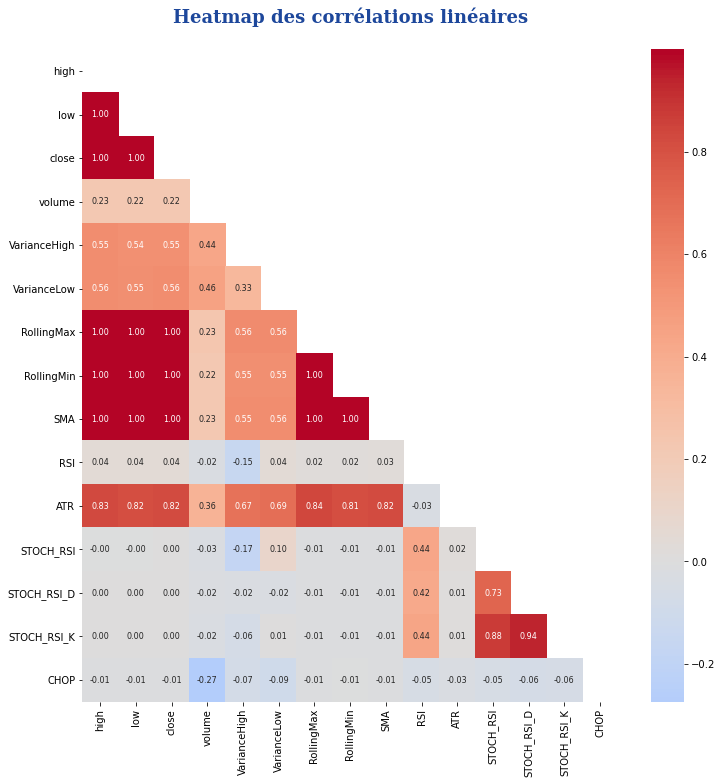

In [5]:
corr = data_t.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", fontdict=font_title);


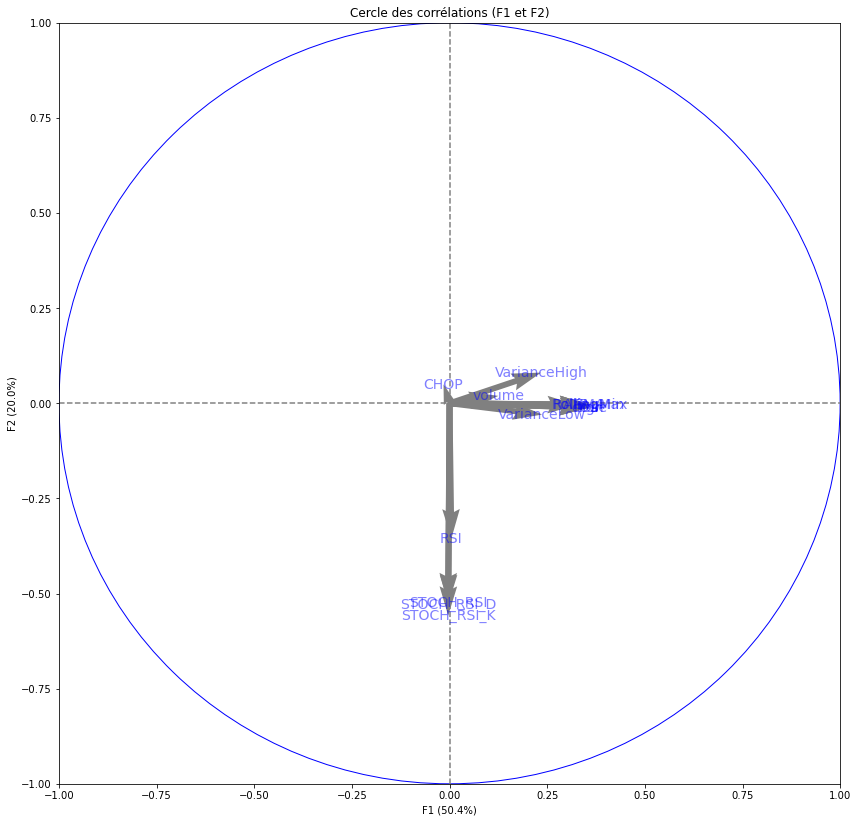

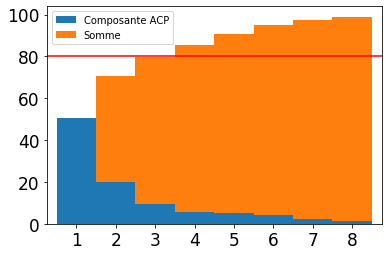

In [6]:
pca = PCA(n_components=8)#len(data_t.columns)) # On paramètre ici pour ne garder que  composantes

# Résultats de l'ACP
data_sortie= pca.fit_transform(data_t)
data_sortie = pd.DataFrame(index=data_t.index,columns= [np.arange(1,1+len(pca.components_)).astype(str)],data=data_sortie)

display_circles(pca.components_, 3, pca, [(0,1),(2,3),(4,5)], labels =data_t.columns)


Yacp = list(pca.explained_variance_ratio_*100)
Xacp = range(1,len(Yacp)+1)
ycum = np.cumsum(Yacp)

d=pd.DataFrame(index=Xacp,columns= ['Composante ACP','Somme'] )
d['Composante ACP']=Yacp
d['Somme']=ycum-Yacp


d.plot(kind='bar',stacked=True,width=1,figsize=(6,4))
plt.axhline(y=80,color="r")
#plt.xlabel("Composante de l'ACP")
#plt.ylabel('variabilité')
plt.xticks(rotation=0,size=17)
plt.yticks(size=17);
#plt.title('ACP par compossante');

In [7]:
data_sortie

,1,2,3,4,5,6,7,8
timestamp,,,,,,,,
2017-08-18 10:00:00,-2.043614,-1.895439,-0.574567,0.460070,0.031012,0.332276,0.466062,-0.358228
2017-08-18 11:00:00,-2.072698,-1.900775,-0.580142,0.579540,-0.276075,0.315186,0.402221,0.068989
2017-08-18 12:00:00,-2.078995,-1.758868,-0.587116,0.605743,-0.312636,0.351294,0.385416,0.301722
2017-08-18 13:00:00,-2.021226,-0.753820,-0.610315,0.819416,-0.329914,0.355815,0.422701,0.833693
2017-08-18 14:00:00,-2.010390,0.312443,-0.575879,0.726571,-0.372389,0.342835,0.435262,0.978367
...,...,...,...,...,...,...,...,...
2021-10-29 06:00:00,7.259209,-0.434263,-1.003046,-1.849666,0.269085,1.156142,-0.033029,0.465800
2021-10-29 07:00:00,7.922361,1.610141,-0.121932,-0.218544,-1.992007,-1.494464,0.891238,0.098782
2021-10-29 08:00:00,7.281961,0.846906,-1.328885,-1.153516,0.981445,1.103316,-0.375472,0.616738


# <a class="anchor" id="section_3"></a>prédiction

In [8]:
X = data_sortie # df.drop('plus_x',axis=1).copy() #
Y = plus_x
    
#X_train1, X_test, Y_train1, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12)
X_train1 = X[:-3600]
Y_train1 = Y[:-3600]
X_test   = X[-3600:]
Y_test   = Y[-3600:]
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train1, Y_train1, test_size=0.2, random_state=13)



from sklearn.model_selection import validation_curve,cross_val_score,GridSearchCV

param=pd.DataFrame(index=None,columns= ['model','name','value'] )

#param.loc[0]=[RandomForestRegressor(n_jobs=3),'ccp_alpha' , [0.99,1.e-1,1.e-2,1.e-3,1.e-4,1.e-5,1.e-6]]
#param.loc[1]=[RandomForestRegressor(n_jobs=3),'n_estimators',range(10,300,20)]
#param.loc[2]=[RandomForestRegressor(n_jobs=3),'max_depth',range(1,150,15)]#taille des arbres
#param.loc[3]=[RandomForestRegressor(n_jobs=3),'bootstrap',[True,False]]

for i in param.index: 
    train_score,val_score=validation_curve(param.loc[i,'model'], X_train,Y_train,
                                           param_name=param.loc[i,'name'],param_range=param.loc[i,'value'],cv=3)
       
    fig = plt.figure(figsize=(15, 6))
    plt.suptitle(f"{str(param.loc[i,'model'])[:str(param.loc[i,'model']).find('(')]}", fontdict=font_title,fontsize=17,y=1.05)
    plt.plot(param.loc[i,'value'],val_score.mean(axis=1),'g',label='validation')
    plt.plot(param.loc[i,'value'],train_score.mean(axis=1),label='train');
    plt.title(param.loc[i,'name'],fontdict=font_title,fontsize=13)
    if param.loc[i,'value'][3]<1 :
        plt.xscale('log')
    plt.legend()
    plt.show()

R2 score train : 0.03
               test 
R2 score test  : -0.00
         MAE   : 0.98
        RMsE   : 1.04
median abs err : 0.96

               Valid 
R2 score valid : 0.01
         MAE   : 0.95
        RMsE   : 1.03
median abs err : 0.89


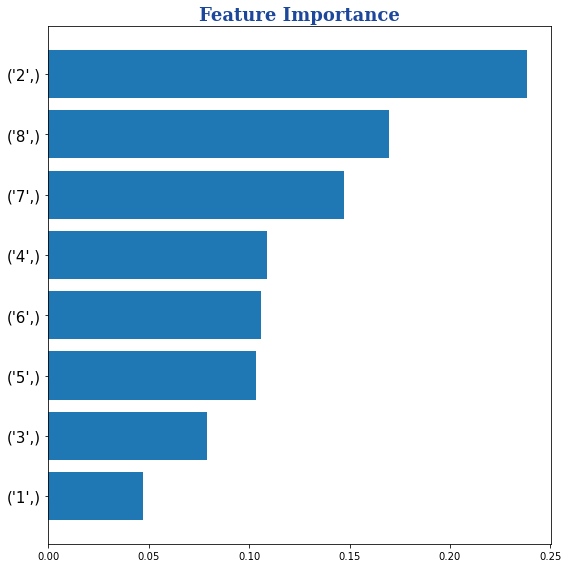

In [9]:
best = RandomForestRegressor(n_jobs=3,ccp_alpha=1.e-3,n_estimators=300,max_depth=17).fit(X_train, Y_train)


print('R2 score train : {:.2f}'.format(r2_score(Y_train, best.predict(X_train))))
y_pred = best.predict(X_test)
print('               test \nR2 score test  : {:.2f}'.format(r2_score(Y_test, y_pred)))
print(f"         MAE   : {mean_absolute_error(Y_test, y_pred):.2f}")
print(f"        RMsE   : {np.sqrt(mean_squared_error(Y_test, y_pred)):.2f}")
print(f"median abs err : {median_absolute_error(Y_test, y_pred):.2f}")
y_pred = best.predict(X_valid)
print('\n               Valid \nR2 score valid : {:.2f}'.format(r2_score(Y_valid, y_pred)))
print(f"         MAE   : {mean_absolute_error(Y_valid, y_pred):.2f}")
print(f"        RMsE   : {np.sqrt(mean_squared_error(Y_valid, y_pred)):.2f}")
print(f"median abs err : {median_absolute_error(Y_valid, y_pred):.2f}")






# Get Feature importance data using feature_importances_ attribute
feature_importance = best.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(data_sortie.columns)[sorted_idx],size=15)
plt.title('Feature Importance',fontdict=font_title)

fig.tight_layout()
plt.show()

from sklearn.model_selection import learning_curve

N,train_score,val_score=learning_curve(best, X_train,Y_train,train_sizes=np.linspace(0.2,1,5),cv=5)


plt.plot(N,val_score.mean(axis=1),'g',label='validation')
plt.plot(N,train_score.mean(axis=1),label='train');
plt.ylabel("pourcentages d'apprentissage",fontsize=15) 
plt.xlabel("train_sizes" ,fontsize=15)  
plt.title("learning_curve", fontdict=font_title)
plt.legend();

# <a class="anchor" id="section_4"></a> évaluation

In [10]:
X_test

,1,2,3,4,5,6,7,8
timestamp,,,,,,,,
2021-06-01 05:00:00,3.860650,1.345399,-0.845923,-0.028410,2.452830,0.376262,0.352127,-0.217534
2021-06-01 06:00:00,4.046282,2.063064,-0.581224,0.987227,0.370924,-1.607776,0.549771,-0.451458
2021-06-01 07:00:00,3.757219,2.027076,-0.957447,0.621783,0.579828,-1.104115,0.158475,0.006497
2021-06-01 08:00:00,4.590623,2.726519,1.316361,1.330745,-0.207476,-1.679552,0.526240,-0.409269
2021-06-01 09:00:00,3.562904,2.527418,-0.573548,-0.303318,0.645641,0.160744,-0.057862,0.143274
...,...,...,...,...,...,...,...,...
2021-10-29 06:00:00,7.259209,-0.434263,-1.003046,-1.849666,0.269085,1.156142,-0.033029,0.465800
2021-10-29 07:00:00,7.922361,1.610141,-0.121932,-0.218544,-1.992007,-1.494464,0.891238,0.098782
2021-10-29 08:00:00,7.281961,0.846906,-1.328885,-1.153516,0.981445,1.103316,-0.375472,0.616738


In [19]:
df

,high,low,close,volume,VarianceHigh,VarianceLow,RollingMax,RollingMin,SMA,RSI,ATR,STOCH_RSI,STOCH_RSI_D,STOCH_RSI_K,CHOP
startTime,,,,,,,,,,,,,,,
2021-10-07 02:00:00+00:00,55217.0,54687.0,55077.0,1.191850e+07,140.0,390.0,55315.0,50707.0,54933.583333,70.323723,647.093508,0.154285,0.485699,0.233263,46.819407
2021-10-07 03:00:00+00:00,55217.0,54742.0,54814.0,5.767295e+06,403.0,72.0,55315.0,50707.0,54918.500000,65.359145,634.801115,0.000000,0.250114,0.051428,54.092795
2021-10-07 04:00:00+00:00,55238.0,54771.0,55074.0,3.257664e+06,164.0,303.0,55315.0,50707.0,54933.750000,67.780723,622.815321,0.130689,0.126561,0.094991,60.360408
2021-10-07 05:00:00+00:00,55074.0,54591.0,54738.0,6.296227e+06,336.0,147.0,55315.0,50707.0,54946.833333,61.771117,612.828512,0.000000,0.063328,0.043563,58.571735
2021-10-07 06:00:00+00:00,54963.0,54411.0,54540.0,3.786287e+06,423.0,129.0,55315.0,50707.0,54947.833333,58.480613,608.483619,0.000000,0.060706,0.043563,58.486567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31 11:00:00+00:00,60902.0,60275.0,60451.0,4.159898e+06,451.0,176.0,62371.0,60692.0,61341.500000,33.607745,468.915867,0.000000,0.028643,0.027287,40.969432
2021-10-31 12:00:00+00:00,60779.0,60135.0,60275.0,6.998370e+06,504.0,140.0,62371.0,60451.0,61166.833333,31.599283,481.421876,0.000000,0.027287,0.027287,39.900455
2021-10-31 13:00:00+00:00,60610.0,59940.0,60350.0,6.841077e+06,260.0,410.0,62371.0,60275.0,61015.666667,33.425144,494.891742,0.058095,0.024646,0.019365,38.253405


test (3600, 19)
0 btc                                          2021-06-07 20:00:00
resultat = 177.0819     score train = 0.8561062 score valid  :  -0.02495607

test (3600, 19)
0 btc                                          2021-06-07 20:00:00
resultat = 177.0819     score train = 0.8554686 score valid  :  -0.02251968

test (3600, 19)
0 btc                                          2021-06-07 23:00:00
resultat = 181.7666     score train = 0.8556919 score valid  :  -0.02162761

test (3600, 19)
0 btc                                          2021-06-07 20:00:00
resultat = 177.0819     score train = 0.8567971 score valid  :  -0.02042729

test (3600, 19)
0 btc                                          2021-06-07 23:00:00
resultat = 181.7666     score train = 0.8561061 score valid  :  -0.02318747

test (3600, 19)
0 btc                                          2021-06-07 20:00:00
resultat = 177.0819     score train = 0.8562752 score valid  :  -0.02384279

test (3600, 19)
0 btc                   

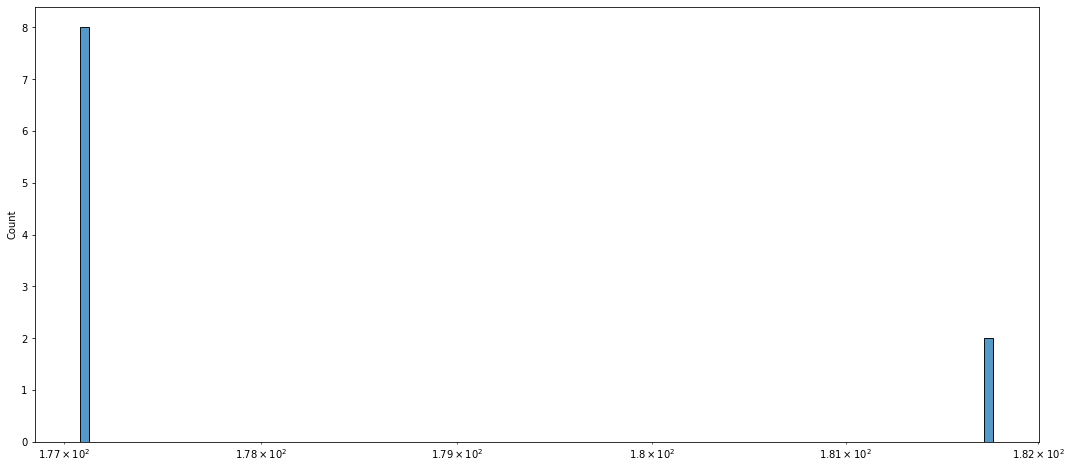

In [12]:
import warnings
warnings.filterwarnings('ignore')

resultat=[]  
  


for i in range(0,10):    



    best = RandomForestRegressor(n_jobs=3).fit(X_train, Y_train)
  
   
    df['predict']=best.predict(X)

    df.loc[:,'buy']  = 0
    df.loc[:,'sell'] = 0
    df.loc[df['predict'] >  1,'buy'] = 1
    df.loc[df['predict'] < -1,'sell'] = 1    
    data_r=df.loc[X_test.index.values,:].copy()
    print(f"test {data_r.shape}")
    resultat.append(evaluation(data_r))
    print(f"resultat = {resultat[i]:.7}     score train = {best.score(X_train, Y_train):.7} score valid  :  {best.score(X_valid, Y_valid):.7}\n")
fig = plt.figure(figsize=(18, 8))
sns.histplot(resultat, bins=100)
plt.xscale('log');

178.01885004052605

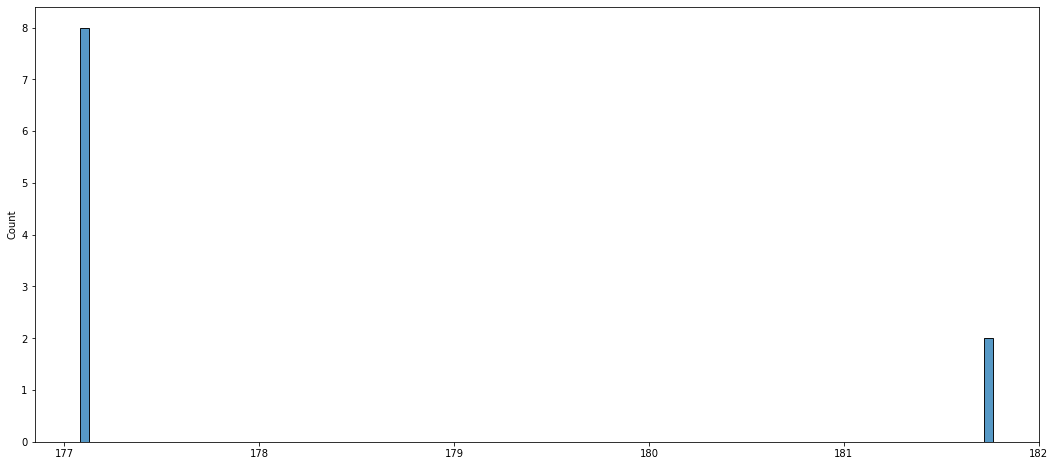

In [13]:


fig = plt.figure(figsize=(18, 8))
sns.histplot(resultat, bins=100)
#plt.xscale('log');
np.array(resultat).mean()

from sklearn.model_selection import learning_curve

N,train_score,val_score=learning_curve(best, X_train_std,Y_train,train_sizes=np.linspace(0.2,1,5),cv=5)


plt.plot(N,val_score.mean(axis=1),'g',label='validation')
plt.plot(N,train_score.mean(axis=1),label='train');
plt.ylabel("pourcentages d'apprentissage",fontsize=15) 
plt.xlabel("train_sizes" ,fontsize=15)  
plt.title("KNN learning_curve", fontdict=font_title)
plt.legend();

## <a class="anchor" id="section_5"></a> Bot

pip install ftx
pip install ciso8601
pip install python-binance


In [14]:
import ftx
#from ftx import FtxClient
import pandas as pd
import ta
import time
import json
from math import *

accountName = 'btcbot'
pairSymbol = 'BTC/USDT'
fiatSymbol = 'USDT'
cryptoSymbol = 'BTC'
myTruncate = 4

client = ftx.FtxClient(api_key='bfv1Ao4wunHoAWe7grNwCHYOyHLLf3XXuDvnx6iH',
                   api_secret='yqW1VItX_fr3OcNQadZyHWwPfvIq6eWlkUhIm8o_', subaccount_name=accountName)

data = client.get_historical_data(
    market_name=pairSymbol, 
    resolution=3600, 
    limit=650, 
    start_time=float(
    round(time.time()))-650*3600, 
    end_time=float(round(time.time())))

    
df = pd.DataFrame(data)
df = df.set_index(df['startTime'])
df.index = pd.to_datetime(df.index)
df = df.drop( ['time','startTime','open'],axis=1)
df=indicator(df).dropna(axis=0) 
df.iloc[-4:]

,high,low,close,volume,VarianceHigh,VarianceLow,RollingMax,RollingMin,SMA,RSI,ATR,STOCH_RSI,STOCH_RSI_D,STOCH_RSI_K,CHOP
startTime,,,,,,,,,,,,,,,
2021-10-31 12:00:00+00:00,60779.0,60135.0,60275.0,6.998370e+06,504.0,140.0,62371.0,60451.0,61166.833333,31.599283,481.421876,0.000000,0.027287,0.027287,39.900455
2021-10-31 13:00:00+00:00,60610.0,59940.0,60350.0,6.841077e+06,260.0,410.0,62371.0,60275.0,61015.666667,33.425144,494.891742,0.058095,0.024646,0.019365,38.253405
2021-10-31 14:00:00+00:00,60738.0,60162.0,60435.0,7.500758e+06,303.0,273.0,62371.0,60275.0,60906.333333,35.525708,500.685189,0.144823,0.038097,0.067639,38.540230
2021-10-31 15:00:00+00:00,60654.0,60321.0,60642.0,1.745082e+06,12.0,321.0,62371.0,60275.0,60817.250000,40.453141,488.707676,0.453655,0.101954,0.218857,40.360964


In [15]:
df=indicator(df).dropna(axis=0) 
df

,high,low,close,volume,VarianceHigh,VarianceLow,RollingMax,RollingMin,SMA,RSI,ATR,STOCH_RSI,STOCH_RSI_D,STOCH_RSI_K,CHOP
startTime,,,,,,,,,,,,,,,
2021-10-07 02:00:00+00:00,55217.0,54687.0,55077.0,1.191850e+07,140.0,390.0,55315.0,50707.0,54933.583333,70.323723,647.093508,0.154285,0.485699,0.233263,46.819407
2021-10-07 03:00:00+00:00,55217.0,54742.0,54814.0,5.767295e+06,403.0,72.0,55315.0,50707.0,54918.500000,65.359145,634.801115,0.000000,0.250114,0.051428,54.092795
2021-10-07 04:00:00+00:00,55238.0,54771.0,55074.0,3.257664e+06,164.0,303.0,55315.0,50707.0,54933.750000,67.780723,622.815321,0.130689,0.126561,0.094991,60.360408
2021-10-07 05:00:00+00:00,55074.0,54591.0,54738.0,6.296227e+06,336.0,147.0,55315.0,50707.0,54946.833333,61.771117,612.828512,0.000000,0.063328,0.043563,58.571735
2021-10-07 06:00:00+00:00,54963.0,54411.0,54540.0,3.786287e+06,423.0,129.0,55315.0,50707.0,54947.833333,58.480613,608.483619,0.000000,0.060706,0.043563,58.486567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31 11:00:00+00:00,60902.0,60275.0,60451.0,4.159898e+06,451.0,176.0,62371.0,60692.0,61341.500000,33.607745,468.915867,0.000000,0.028643,0.027287,40.969432
2021-10-31 12:00:00+00:00,60779.0,60135.0,60275.0,6.998370e+06,504.0,140.0,62371.0,60451.0,61166.833333,31.599283,481.421876,0.000000,0.027287,0.027287,39.900455
2021-10-31 13:00:00+00:00,60610.0,59940.0,60350.0,6.841077e+06,260.0,410.0,62371.0,60275.0,61015.666667,33.425144,494.891742,0.058095,0.024646,0.019365,38.253405


max=0
trigger = True
while trigger == True:
    try:

        #chargement
        data = client.get_historical_data(
            market_name=pairSymbol, 
            resolution=3600, 
            limit=650, 
            start_time=float(
            round(time.time()))-650*3600, 
            end_time=float(round(time.time())))  
        df = pd.DataFrame(data)
        df = df.set_index(df['startTime'])
        df.index = pd.to_datetime(df.index)
        df = df.drop( ['time','startTime','open'],axis=1)


        #prediction
        df = indicator(df).dropna(axis=0) 
        X_unique  = preprocessor.transform(df)
        predict=best.predict(X_unique)[-1]

        if abs(max) < abs(predict) : max=predict

        #achat/vente
        actualPrice = df['close'].iloc[-1]
        fiatAmount = getBalance(client, fiatSymbol)
        cryptoAmount = getBalance(client, cryptoSymbol)
        print(f"pred {predict:.4}  actualPrice {actualPrice} fiatAmount {fiatAmount:.4} cryptoAmount {cryptoAmount:.4}")

        if float(fiatAmount) > 10 and       predict > 0.4  :
            quantityBuy = truncate(float(fiatAmount)/actualPrice, myTruncate)
            buyOrder = client.place_order(
                market=pairSymbol, 
                side="buy", 
                price=None, 
                size=quantityBuy, 
                type='market')
            print("\n    buyOrder" ,buyOrder)

        if float(cryptoAmount) > 0.0002 and  predict < -0.3:
            buyOrder = client.place_order(
                market=pairSymbol, 
                side="sell", 
                price=None, 
                size=truncate(cryptoAmount, myTruncate), 
                type='market')
            print("\n    buyOrder" ,buyOrder)

        
        time.sleep((65-time.gmtime(time.time()).tm_sec))
        
    
    except  KeyboardInterrupt:
        trigger = False
print(f" max = {max}")


print('shutdown complete')

In [16]:
(61-time.gmtime(time.time()).tm_min)*60-time.gmtime(time.time()).tm_sec

2273

In [17]:
max

<function max>

In [18]:

dt = None #resultat isoler
dt = pd.DataFrame(columns = ['date','position', 'price', 'frais' ,'fiat', 'coins', 'wallet', 'drawBack'])

usdt = 1000
initalWallet = usdt
coin = 0
wallet = 1000
lastAth = 0
lastIndex = df.first_valid_index()
fee = 0.0007

for index, row in dfTest.iterrows():
  #Buy
  if row['EMA28'] > row['EMA48'] and row['STOCH_RSI'] < 0.8 and  usdt > 0:
    coin = usdt / row['close']
    frais = fee * coin
    coin = coin - frais
    usdt = 0
    wallet = coin * row['close']
    if wallet > lastAth:
        lastAth = wallet
    # print("Buy COIN at",df['close'][index],'$ the', index)
    myrow = {'date': index,'position': "Buy",'price': row['close'],'frais': frais,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)

  #Sell
  if row['EMA28'] < row['EMA48'] and row['STOCH_RSI'] > 0.2 and coin > 0:
    usdt = coin * row['close']
    frais = fee * usdt
    usdt = usdt - frais
    coin = 0
    wallet = usdt
    if wallet > lastAth:
      lastAth = wallet
    # print("Sell COIN at",df['close'][index],'$ the', index)
    myrow = {'date': index,'position': "Sell",'price': row['close'],'frais': frais,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  lastIndex = index

#///////////////////////////////////////
print("Period : [" + str(dfTest.index[0]) + "] -> [" +str(dfTest.index[len(dfTest)-1]) + "]")
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat'] = dt['wallet'].diff()
dt['resultat%'] = dt['wallet'].pct_change()*100
dt.loc[dt['position']=='Buy','resultat'] = None
dt.loc[dt['position']=='Buy','resultat%'] = None

dt['tradeIs'] = ''
dt.loc[dt['resultat']>0,'tradeIs'] = 'Good'
dt.loc[dt['resultat']<=0,'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPorcentage = ((lastClose - iniClose)/iniClose) * 100
algoPorcentage = ((wallet - initalWallet)/initalWallet) * 100
vsHoldPorcentage = ((algoPorcentage - holdPorcentage)/holdPorcentage) * 100

print("Starting balance : 1000 $")
print("Final balance :",round(wallet,2),"$")
print("Performance vs US Dollar :",round(algoPorcentage,2),"%")
print("Buy and Hold Performence :",round(holdPorcentage,2),"%")
print("Performance vs Buy and Hold :",round(vsHoldPorcentage,2),"%")
print("Number of negative trades : ",dt.groupby('tradeIs')['date'].nunique()['Bad'])
print("Number of positive trades : ",dt.groupby('tradeIs')['date'].nunique()['Good'])
print("Average Positive Trades : ",round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(),2),"%")
print("Average Negative Trades : ",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(),2),"%")
idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
print("Best trade +"+str(round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(),2)),"%, the ",dt['date'][idbest])
print("Worst trade",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(),2),"%, the ",dt['date'][idworst])
print("Worst drawBack", str(100*round(dt['drawBack'].min(),2)),"%")
print("Total fee : ",round(dt['frais'].sum(),2),"$")

dt[['wallet','price']].plot(subplots=True, figsize=(12,10))
print('PLOT')

NameError: name 'dfTest' is not defined